# Music Genre Classification

In [1]:
%matplotlib inline

import warnings
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning

warnings.filterwarnings("ignore", message=".*The 'nopython' keyword.*")
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)

import pandas as pd
import numpy as np
from ydata_profiling import ProfileReport

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder

from tqdm.auto import tqdm, trange
import pickle

In [2]:
df_full = pd.read_csv('/kaggle/input/spotify-tracks-genre-dataset/train.csv')
df_full.head()

,Unnamed: 0,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,...,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,...,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,...,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,...,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,...,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


# EDA

In [3]:
df_full.isnull().sum()

Unnamed: 0          0
track_id            0
artists             1
album_name          1
track_name          1
popularity          0
duration_ms         0
explicit            0
danceability        0
energy              0
key                 0
loudness            0
mode                0
speechiness         0
acousticness        0
instrumentalness    0
liveness            0
valence             0
tempo               0
time_signature      0
track_genre         0
dtype: int64

**Removing columns Unnamed, track_id, artists, album_name, track_name, popularity and explicit as these are all almost unique and we don't want that in our training.**

In [4]:
df = df_full

del df['Unnamed: 0']
del df['track_id']
del df['artists']
del df['album_name']
del df['track_name']
del df['popularity']
del df['explicit']

df.head()

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,230666,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,149610,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,210826,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,201933,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,198853,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


**Renaming track_genre column to genre to make it easier to reference**

In [5]:
df.rename(columns = {'track_genre':'genre'}, inplace = True)

In [6]:
numerical = df.select_dtypes(include=np.number).columns.tolist()
numerical

['duration_ms',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature']

In [7]:
categorical = df.select_dtypes(exclude=np.number).columns.tolist()
categorical

['genre']

In [8]:
df.genre.value_counts()

genre
acoustic             1000
punk-rock            1000
progressive-house    1000
power-pop            1000
pop                  1000
                     ... 
folk                 1000
emo                  1000
electronic           1000
electro              1000
world-music          1000
Name: count, Length: 114, dtype: int64

In [9]:
df_nums = df.copy()
df_nums = df_nums[numerical]

**Correlation Matrix**

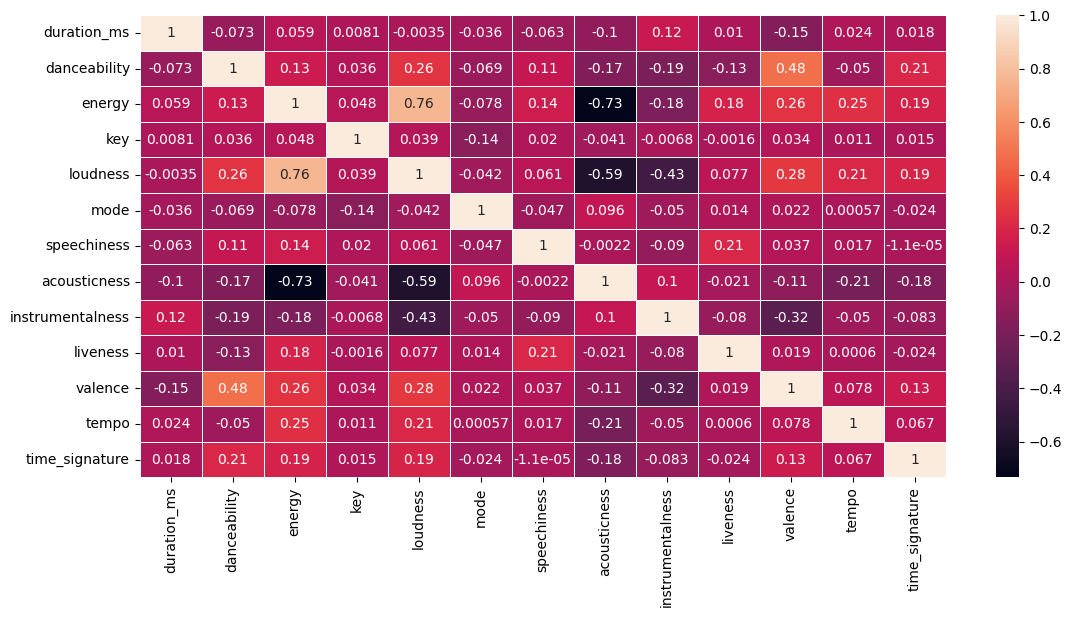

In [10]:
plt.figure(figsize=(13,6))
corr_matrix = df_nums.corr()
sn.heatmap(corr_matrix, linewidths=.7, annot=True)
plt.show()

**Energy and Loudness have the biggest correlations.**

## Data cleanup

In [11]:
classes = df.genre.unique()
print(classes)

['acoustic' 'afrobeat' 'alt-rock' 'alternative' 'ambient' 'anime'
 'black-metal' 'bluegrass' 'blues' 'brazil' 'breakbeat' 'british'
 'cantopop' 'chicago-house' 'children' 'chill' 'classical' 'club' 'comedy'
 'country' 'dance' 'dancehall' 'death-metal' 'deep-house' 'detroit-techno'
 'disco' 'disney' 'drum-and-bass' 'dub' 'dubstep' 'edm' 'electro'
 'electronic' 'emo' 'folk' 'forro' 'french' 'funk' 'garage' 'german'
 'gospel' 'goth' 'grindcore' 'groove' 'grunge' 'guitar' 'happy'
 'hard-rock' 'hardcore' 'hardstyle' 'heavy-metal' 'hip-hop' 'honky-tonk'
 'house' 'idm' 'indian' 'indie-pop' 'indie' 'industrial' 'iranian'
 'j-dance' 'j-idol' 'j-pop' 'j-rock' 'jazz' 'k-pop' 'kids' 'latin'
 'latino' 'malay' 'mandopop' 'metal' 'metalcore' 'minimal-techno' 'mpb'
 'new-age' 'opera' 'pagode' 'party' 'piano' 'pop-film' 'pop' 'power-pop'
 'progressive-house' 'psych-rock' 'punk-rock' 'punk' 'r-n-b' 'reggae'
 'reggaeton' 'rock-n-roll' 'rock' 'rockabilly' 'romance' 'sad' 'salsa'
 'samba' 'sertanejo' 'show

**Too many genres and data, we should look to reduce**

In [12]:
drop_genres = ['acoustic','alternative','afrobeat','alt-rock','ambient','anime','black-metal','bluegrass','blues','brazil','breakbeat','british','cantopop','chicago-house','children','chill','club','comedy','dancehall','death-metal','deep-house','detroit-techno','disney','drum-and-bass','dub','dubstep','edm','electro','emo','folk','forro','french','funk','garage','german','gospel','goth','grindcore','groove','grunge','guitar','happy','hard-rock','hardcore','hardstyle','heavy-metal','honky-tonk','idm','indian','indie-pop','indie','industrial','iranian','j-dance','j-idol','j-pop','j-rock','k-pop','kids','latin','latino','malay','mandopop','metalcore','minimal-techno','mpb','new-age','opera','pagode','party','piano','pop-film','power-pop','progressive-house','psych-rock','punk-rock','punk','reggae','reggaeton','rock-n-roll','rockabilly','romance','sad','salsa','samba','sertanejo','show-tunes','singer-songwriter','ska','sleep','songwriter','soul','spanish','study','swedish','synth-pop','tango','techno','trance','trip-hop','turkish','world-music']

In [13]:
df.drop(df[df['genre'].isin(drop_genres)].index, inplace = True)

In [14]:
classes = df.genre.unique()
print(classes)

['classical' 'country' 'dance' 'disco' 'electronic' 'hip-hop' 'house'
 'jazz' 'metal' 'pop' 'r-n-b' 'rock']


**Down to 12 genres from 114**

In [15]:
df.reset_index(drop=True)

,duration_ms,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,genre
0,298266,0.643,0.268,11,-15.073,0,0.0900,0.5930,0.000002,0.316,0.620,143.813,4,classical
1,482586,0.484,0.898,0,-4.132,1,0.1640,0.3650,0.000000,0.091,0.680,91.975,4,classical
2,219437,0.608,0.638,11,-6.008,0,0.0292,0.5810,0.017200,0.448,0.439,140.109,4,classical
3,299146,0.695,0.293,11,-16.278,0,0.0431,0.5960,0.015800,0.132,0.637,143.804,4,classical
4,387716,0.583,0.308,7,-18.303,0,0.0465,0.5810,0.010600,0.257,0.241,118.226,4,classical
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,253626,0.440,0.838,9,-6.196,1,0.0423,0.0956,0.000000,0.473,0.619,138.908,4,rock
11996,253626,0.440,0.838,9,-6.196,1,0.0423,0.0956,0.000000,0.473,0.619,138.908,4,rock
11997,253626,0.440,0.838,9,-6.196,1,0.0423,0.0956,0.000000,0.473,0.619,138.908,4,rock
11998,253626,0.440,0.838,9,-6.196,1,0.0423,0.0956,0.000000,0.473,0.619,138.908,4,rock


In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 12000 entries, 16000 to 91999
Data columns (total 14 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   duration_ms       12000 non-null  int64  
 1   danceability      12000 non-null  float64
 2   energy            12000 non-null  float64
 3   key               12000 non-null  int64  
 4   loudness          12000 non-null  float64
 5   mode              12000 non-null  int64  
 6   speechiness       12000 non-null  float64
 7   acousticness      12000 non-null  float64
 8   instrumentalness  12000 non-null  float64
 9   liveness          12000 non-null  float64
 10  valence           12000 non-null  float64
 11  tempo             12000 non-null  float64
 12  time_signature    12000 non-null  int64  
 13  genre             12000 non-null  object 
dtypes: float64(9), int64(4), object(1)
memory usage: 1.4+ MB


In [17]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.genre.values
y_val = df_val.genre.values
y_test = df_test.genre.values

del df_train['genre']
del df_val['genre']
del df_test['genre']

len(df_train), len(df_val), len(df_test)

(7200, 2400, 2400)

In [18]:
cols = df.select_dtypes(include=np.number).columns.tolist()
cols

['duration_ms',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'time_signature']

In [19]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [20]:
train_dicts = df_train[cols].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Feature Importance

In [21]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [22]:
rf.feature_importances_

array([0.13043329, 0.10139142, 0.09409939, 0.10219664, 0.07538897,
       0.04811665, 0.07197536, 0.10001092, 0.01483926, 0.08872003,
       0.07985641, 0.00671858, 0.08625307])

In [23]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances

,feature,importance
0,acousticness,0.130433
1,danceability,0.101391
2,duration_ms,0.094099
3,energy,0.102197
4,instrumentalness,0.075389
5,key,0.048117
6,liveness,0.071975
7,loudness,0.100011
8,mode,0.014839
9,speechiness,0.088720


In [24]:
df_importances.sort_values(by='importance', ascending=False)

,feature,importance
0,acousticness,0.130433
3,energy,0.102197
1,danceability,0.101391
7,loudness,0.100011
2,duration_ms,0.094099
9,speechiness,0.088720
12,valence,0.086253
10,tempo,0.079856
4,instrumentalness,0.075389
6,liveness,0.071975


**Deleting key, mode and time_signature columns**

In [25]:
del df['key']
del df['mode']
del df['time_signature']

## Setting up Training Data

In [26]:
df_train_full, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_train_full, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.genre.values
y_val = df_val.genre.values
y_test = df_test.genre.values

del df_train['genre']
del df_val['genre']
del df_test['genre']

len(df_train), len(df_val), len(df_test)

(7200, 2400, 2400)

In [27]:
cols = df.select_dtypes(include=np.number).columns.tolist()
cols

['duration_ms',
 'danceability',
 'energy',
 'loudness',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo']

In [28]:
le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_val = le.fit_transform(y_val)
y_test = le.fit_transform(y_test)

In [29]:
train_dicts = df_train[cols].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train = dv.fit_transform(train_dicts)

val_dict = df_val[cols].to_dict(orient='records')
X_val = dv.transform(val_dict)

## Logistic Regression

In [30]:
model_lr = LogisticRegression(multi_class='ovr', solver='lbfgs', random_state=1)
model_lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=1)

In [31]:
y_pred = model_lr.predict_proba(X_val)
roc_auc_score(y_val, y_pred, multi_class='ovr')

0.626932539481431

**Logistic Regression has a low score**

## Decision Tree Classifier

In [32]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

DecisionTreeClassifier()

In [33]:
y_pred = dt.predict_proba(X_val)
roc_auc_score(y_val, y_pred, multi_class='ovr')

0.7363285239240976

In [34]:
dt = DecisionTreeClassifier(max_depth=2)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=2)

In [35]:
y_pred = dt.predict_proba(X_train)
auc = roc_auc_score(y_train, y_pred, multi_class='ovr')
print('train:', auc)

y_pred = dt.predict_proba(X_val)
auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
print('val:', auc)

train: 0.6769320087676877
val: 0.6672567806741049


In [36]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- acousticness <= 0.90
|   |--- danceability <= 0.62
|   |   |--- class: 8
|   |--- danceability >  0.62
|   |   |--- class: 5
|--- acousticness >  0.90
|   |--- instrumentalness <= 0.01
|   |   |--- class: 7
|   |--- instrumentalness >  0.01
|   |   |--- class: 0



In [37]:
depths = [ 5, 10, 15, 20, 25, 30, 40, 50, None]

for depth in depths: 
    dt = DecisionTreeClassifier(max_depth=depth)
    dt.fit(X_train, y_train)
    y_pred = dt.predict_proba(X_val)
    auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
    
    print('%4s -> %.3f' % (depth, auc))

   5 -> 0.754
  10 -> 0.803
  15 -> 0.766
  20 -> 0.736
  25 -> 0.735
  30 -> 0.730
  40 -> 0.737
  50 -> 0.731
None -> 0.736


In [38]:
scores = []

for depth in [5, 7, 10, 12]:
    for s in [1, 5, 10, 15, 20, 500, 100, 200]:
        dt = DecisionTreeClassifier(max_depth=depth, min_samples_leaf=s)
        dt.fit(X_train, y_train)

        y_pred = dt.predict_proba(X_val)
        auc = roc_auc_score(y_val, y_pred, multi_class='ovr')
        
        scores.append((depth, s, auc))

In [39]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

In [40]:
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
df_scores_pivot.round(3)

auc                     
max_depth            5      7      10     12
min_samples_leaf                            
1                 0.754  0.774  0.802  0.788
5                 0.754  0.778  0.812  0.812
10                0.754  0.777  0.814  0.822
15                0.753  0.778  0.819  0.827
20                0.755  0.781  0.820  0.827
100               0.758  0.785  0.804  0.804
200               0.762  0.786  0.788  0.788
500               0.753  0.755  0.755  0.755

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

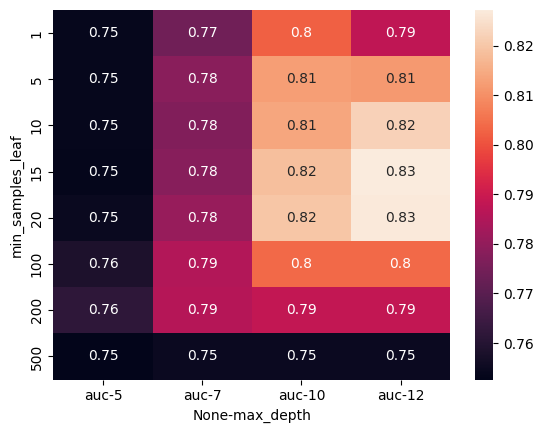

In [41]:
sn.heatmap(df_scores_pivot, annot=True)

In [42]:
dt = DecisionTreeClassifier(max_depth=12, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=15)

**Looks like the best parameters for Decision Tree are:**

* max_depth = 12
* min_samples_leaf = 15

In [43]:
print(export_text(dt, feature_names=list(dv.get_feature_names_out())))

|--- acousticness <= 0.90
|   |--- danceability <= 0.62
|   |   |--- acousticness <= 0.01
|   |   |   |--- acousticness <= 0.00
|   |   |   |   |--- speechiness <= 0.05
|   |   |   |   |   |--- tempo <= 125.11
|   |   |   |   |   |   |--- duration_ms <= 242248.50
|   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |   |   |--- duration_ms >  242248.50
|   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |   |--- tempo >  125.11
|   |   |   |   |   |   |--- duration_ms <= 265733.00
|   |   |   |   |   |   |   |--- duration_ms <= 214197.00
|   |   |   |   |   |   |   |   |--- class: 2
|   |   |   |   |   |   |   |--- duration_ms >  214197.00
|   |   |   |   |   |   |   |   |--- speechiness <= 0.04
|   |   |   |   |   |   |   |   |   |--- class: 11
|   |   |   |   |   |   |   |   |--- speechiness >  0.04
|   |   |   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |   |   |--- duration_ms >  265733.00
|   |   |   |   |   |   |   |--- class: 8
|   |   |   |   |--- speechine

## Random Forest Classifier

In [44]:
rf = RandomForestClassifier(random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(random_state=1)

In [45]:
y_pred = rf.predict_proba(X_val)
roc_auc_score(y_val, y_pred, multi_class='ovr')

0.912386985943401

**Tuning max_depth**

In [46]:
scores = []

for d in tqdm([5, 10, 15, 20]):
    for n in trange(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=d,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)
        auc = roc_auc_score(y_val, y_pred, multi_class='ovr')

        scores.append((d, n, auc))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [47]:
columns = ['max_depth', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

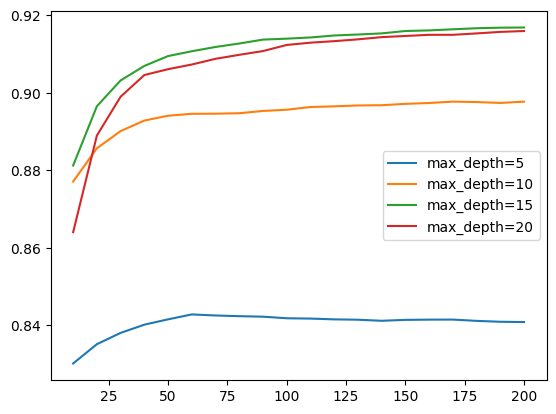

In [48]:
for d in [5, 10, 15, 20]:
    df_subset = df_scores[df_scores.max_depth == d]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='max_depth=%d' % d)

plt.legend()

**Tuning min_samples_leaf**

In [49]:
max_depth = 15

In [50]:
scores = []

for s in tqdm([1, 3, 5, 10, 50]):
    for n in trange(10, 201, 10):
        rf = RandomForestClassifier(n_estimators=n,
                                    max_depth=max_depth,
                                    min_samples_leaf=s,
                                    random_state=1)
        rf.fit(X_train, y_train)

        y_pred = rf.predict_proba(X_val)
        auc = roc_auc_score(y_val, y_pred, multi_class='ovr')

        scores.append((s, n, auc))

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

In [51]:
columns = ['min_samples_leaf', 'n_estimators', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)

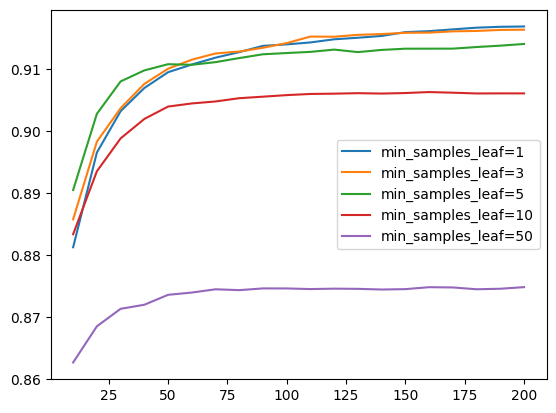

In [52]:
values = [1, 3, 5, 10, 50]

for s in values:
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    
    plt.plot(df_subset.n_estimators, df_subset.auc,
             label='min_samples_leaf=%d' % s)

plt.legend()

In [53]:
min_samples_leaf = 3

In [54]:
rf = RandomForestClassifier(n_estimators=125,
                            max_depth=max_depth,
                            min_samples_leaf=min_samples_leaf,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=125,
                       random_state=1)

**Looks like the best parameters for Random Forest are:**

* max_depth = 15
* min_samples_leaf = 3
* n_estimators = 125

# Selecting a Model

## Logistic Regression

In [55]:
model_lr = LogisticRegression(multi_class='ovr', solver='lbfgs', random_state=1)
model_lr.fit(X_train, y_train)

LogisticRegression(multi_class='ovr', random_state=1)

In [56]:
y_pred = model_lr.predict_proba(X_val)
roc_auc_score(y_val, y_pred, multi_class='ovr')

0.626932539481431

## Decision Tree

In [57]:
dt = DecisionTreeClassifier(max_depth=12, min_samples_leaf=15)
dt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=12, min_samples_leaf=15)

In [58]:
y_pred = dt.predict_proba(X_val)
roc_auc_score(y_val, y_pred, multi_class='ovr')

0.8267771575016983

## Random Forest

In [59]:
rf = RandomForestClassifier(n_estimators=125,
                            max_depth=15,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=125,
                       random_state=1)

In [60]:
y_pred = rf.predict_proba(X_val)
roc_auc_score(y_val, y_pred, multi_class='ovr')

0.9151372593981607

**Random Forest has the best accuracy**

## Training the model on the full dataset

In [61]:
df_train_full.head()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
64590,150412,0.569,0.489,-5.594,0.0400,0.238,0.000,0.290,0.543,123.573,jazz
20901,180000,0.638,0.717,-4.722,0.0337,0.346,0.000,0.105,0.249,100.027,dance
25461,208840,0.595,0.921,-7.329,0.0987,0.179,0.000,0.812,0.937,102.350,disco
64895,227920,0.334,0.470,-12.588,0.0322,0.941,0.967,0.127,0.623,51.206,jazz
16043,311786,0.164,0.167,-17.032,0.0440,0.594,0.368,0.224,0.154,87.069,classical


In [62]:
df_train_full = df_train_full.reset_index(drop=True)

In [63]:
df_train_full.head()

,duration_ms,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genre
0,150412,0.569,0.489,-5.594,0.0400,0.238,0.000,0.290,0.543,123.573,jazz
1,180000,0.638,0.717,-4.722,0.0337,0.346,0.000,0.105,0.249,100.027,dance
2,208840,0.595,0.921,-7.329,0.0987,0.179,0.000,0.812,0.937,102.350,disco
3,227920,0.334,0.470,-12.588,0.0322,0.941,0.967,0.127,0.623,51.206,jazz
4,311786,0.164,0.167,-17.032,0.0440,0.594,0.368,0.224,0.154,87.069,classical


In [64]:
y_train_full = df_train_full.genre.values

In [65]:
del df_train_full['genre']

In [66]:
dicts_train_full = df_train_full.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
X_train_full = dv.fit_transform(dicts_train_full)

dicts_test = df_test.to_dict(orient='records')
X_test = dv.transform(dicts_test)

In [67]:
le = LabelEncoder()
y_train_full = le.fit_transform(y_train_full)

In [68]:
rf = RandomForestClassifier(n_estimators=125,
                            max_depth=15,
                            min_samples_leaf=3,
                            random_state=1)
rf.fit(X_train_full, y_train_full)

RandomForestClassifier(max_depth=15, min_samples_leaf=3, n_estimators=125,
                       random_state=1)

In [69]:
y_pred = rf.predict_proba(X_test)
roc_auc_score(y_test, y_pred, multi_class='ovr')

0.9190911734222412

In [70]:
df_train_full.iloc[3].to_dict()

{'duration_ms': 227920.0,
 'danceability': 0.334,
 'energy': 0.47,
 'loudness': -12.588,
 'speechiness': 0.0322,
 'acousticness': 0.941,
 'instrumentalness': 0.967,
 'liveness': 0.127,
 'valence': 0.623,
 'tempo': 51.206}

In [71]:
print(classes[y_train_full[3]])

jazz


# Exporting Model

In [72]:
output_file = 'model.bin'

In [73]:
f_out = open(output_file, 'wb') 
pickle.dump((dv, rf), f_out)
f_out.close()